<h1>IBM Data Science Capstone Project</h1>
<h4 style="text-align:right;">- Jasleen Singh<h4>

In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools
pd.options.mode.chained_assignment = None

In [2]:
owid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv').fillna(0)
!curl https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -o world_countries.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 51  246k   51  128k    0     0  55775      0  0:00:04  0:00:02  0:00:02 55751
100  246k  100  246k    0     0   103k      0  0:00:02  0:00:02 --:--:--  103k


<h1>Data Processing</h1>

In [3]:
data_cln_dct = {'cardiovasc_death_rate' : '', 'stringency_index':'', 'female_smokers' : '', 'male_smokers' : '', 'handwashing_facilities' : '', 'hospital_beds_per_thousand' : '', 'human_development_index' : ''}
rplc_dct = {'total_cases': '', 'new_cases': '', 'total_deaths': '', 'new_deaths': '', 'median_age': '', 'aged_65_older':'', 'aged_70_older':''}
rplc_dct.update(data_cln_dct)

owid = owid.replace({'location':'United States'}, 'United States of America')

owid['dayofyear'] = pd.to_datetime(owid['date']).dt.dayofyear
owid = owid.replace(rplc_dct, 0)
owid = owid[(owid['iso_code']!='') & (owid['location']!='World') & (owid['dayofyear']>31) & (owid['dayofyear']<245) & (owid['median_age']>0) & (owid['aged_65_older']>0) & (owid['aged_70_older']>0) ].reset_index(drop=True) ### 245 indicates data till end of august
owid = owid.astype({'total_cases':'Int64','new_cases':'Int64','total_deaths':'Int64','new_deaths':'Int64'})
print(owid.shape)
owid['fraction_cases'] = 0; owid['fraction_deaths'] = 0
for i in set(owid['iso_code']):
    inddf = owid[owid['iso_code'] == i]
    ctrymx = inddf['total_cases'].iloc[-1]
    cntymxdth = inddf['total_deaths'].iloc[-1]
    owid['fraction_cases'][owid['iso_code'] == i] = inddf['new_cases'].astype('int') / int(ctrymx)
    if (cntymxdth!=0): owid['fraction_deaths'][owid['iso_code'] == i] = inddf['new_deaths'].astype('int') / int(cntymxdth)
    for j in list(data_cln_dct.keys()):
        owid[j][owid['iso_code'] == i] = inddf.groupby(['location'])[j].max()[0]
    

owid.to_csv('covid19_main.csv',index=False)
owid.head()

(33424, 42)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,dayofyear,fraction_cases,fraction_deaths
0,ABW,North America,Aruba,2020-03-13,2,2,0.000,0,0,0.0,...,11.62,0.0,0.0,0.0,0.0,76.29,0.0,73,0.001002,0.0
1,ABW,North America,Aruba,2020-03-19,0,0,0.286,0,0,0.0,...,11.62,0.0,0.0,0.0,0.0,76.29,0.0,79,0.000000,0.0
2,ABW,North America,Aruba,2020-03-20,4,2,0.286,0,0,0.0,...,11.62,0.0,0.0,0.0,0.0,76.29,0.0,80,0.001002,0.0
3,ABW,North America,Aruba,2020-03-21,0,0,0.286,0,0,0.0,...,11.62,0.0,0.0,0.0,0.0,76.29,0.0,81,0.000000,0.0
4,ABW,North America,Aruba,2020-03-22,0,0,0.286,0,0,0.0,...,11.62,0.0,0.0,0.0,0.0,76.29,0.0,82,0.000000,0.0


<h1>Data Visualisation</h1>

In [4]:
import folium
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Data Visualisation over World Map</h2>

In [5]:
world_geo = r'world_countries.json'
df_map = owid[owid['location'] != 'World']
df_map = df_map.groupby(['location'])['location', 'total_deaths'].max() 

threshold_scale = np.linspace(df_map['total_deaths'].min(),
                              df_map['total_deaths'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1

world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
world_map.choropleth(
    geo_data=world_geo,
    data=df_map,
    columns=['location', 'total_deaths'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Death Count per Country',
    reset=True
)
world_map

<h2>Data Visualisation over Graph</h2>

For Data visualisation over graph, we will create and function and re-use it for all type of graph comparison

In [6]:
cntr_analysi = ['United States of America', 'India', 'Italy', 'Brazil', 'Russia']
vis_df = owid[owid['location'].isin(cntr_analysi)]
def plt_line(vis_df_fn, x_fld, y_fld, title_st, x_st, y_st):
    vis_df_fn.set_index(x_fld, inplace=True)
    vis_df_fn = vis_df_fn.pivot(columns='location')
    vis_df_fn.columns = vis_df_fn.columns.droplevel(0)
    ax = vis_df_fn.plot(kind = 'line', figsize=(15, 6), fontsize = 12)
    ax.set_title(title_st, size = 16, y=1.05)
    ax.set_xlabel(x_st, fontsize = 14)
    ax.set_ylabel(y_st, fontsize = 14)
    ax.legend(fontsize = 14)


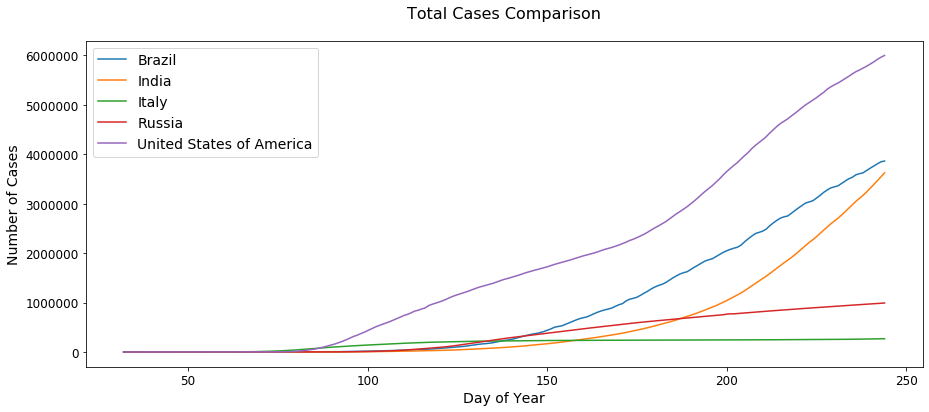

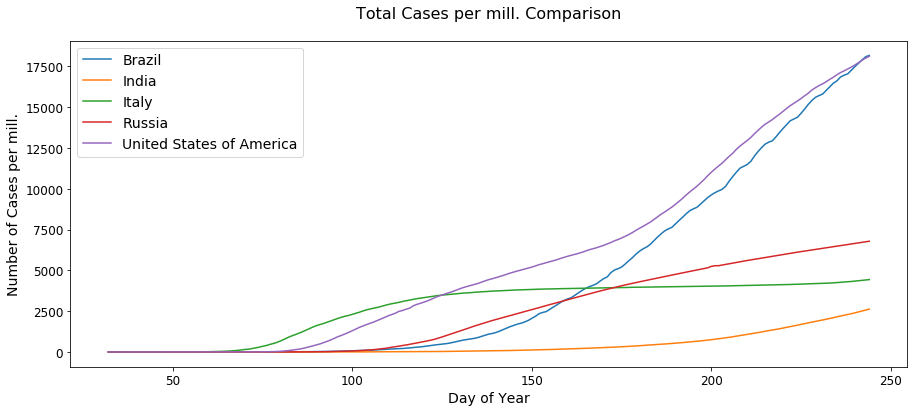

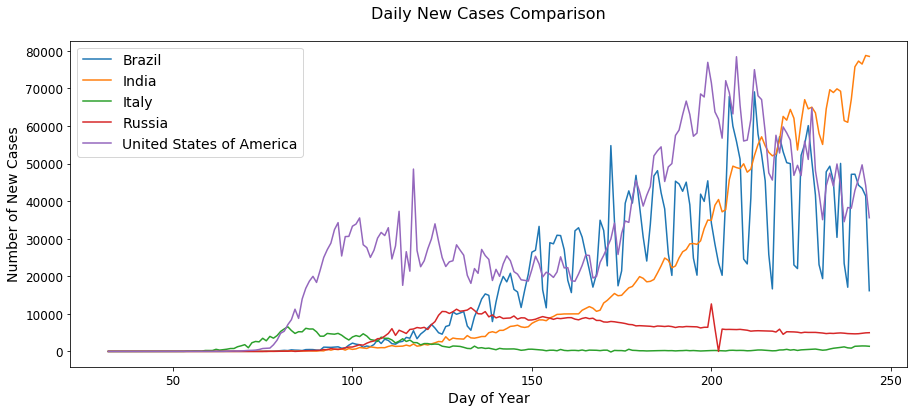

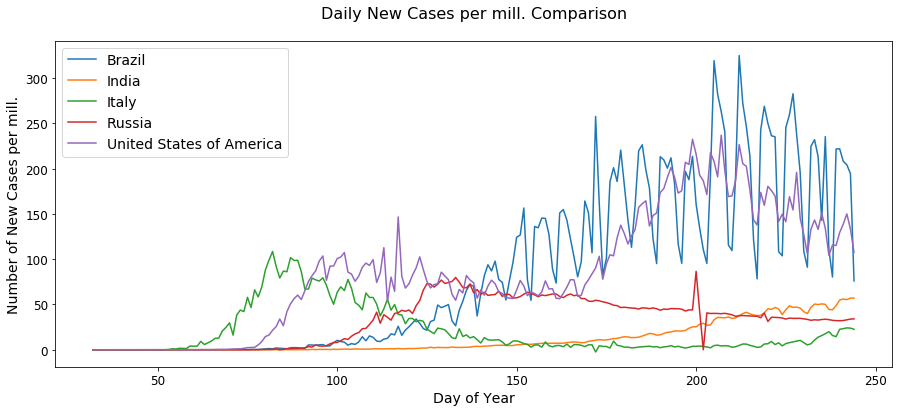

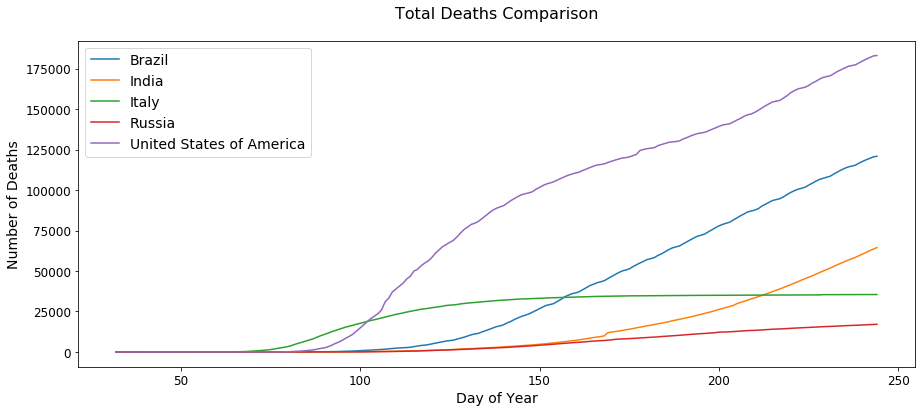

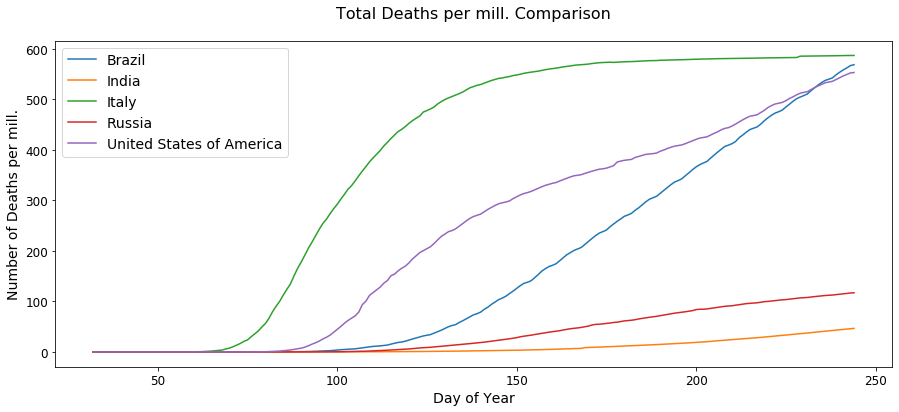

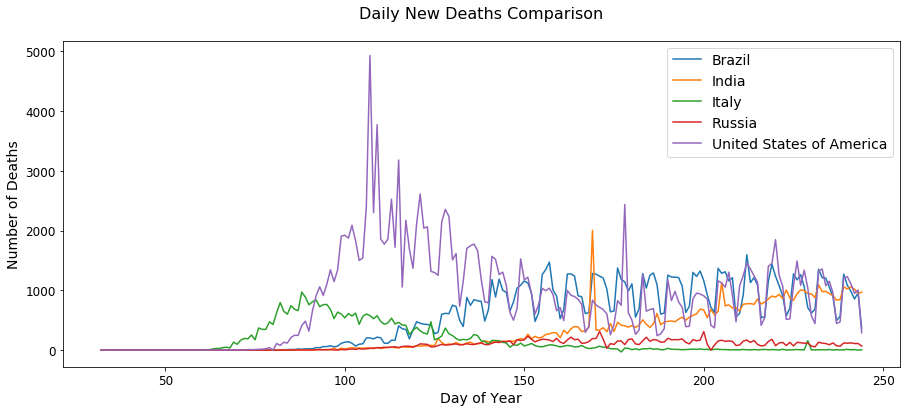

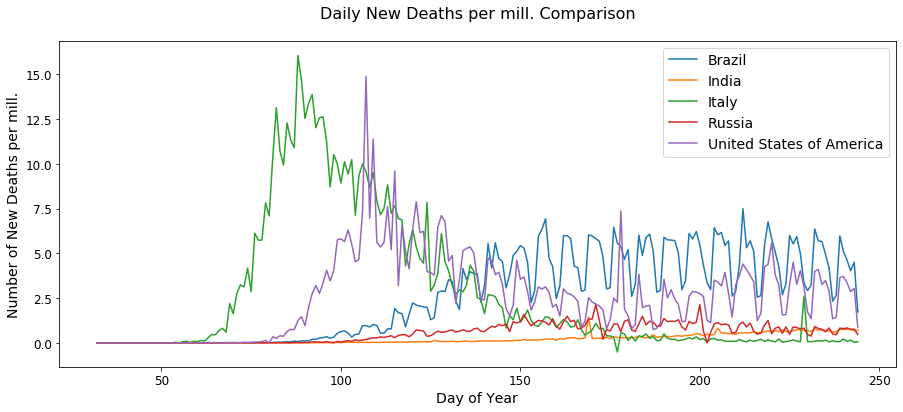

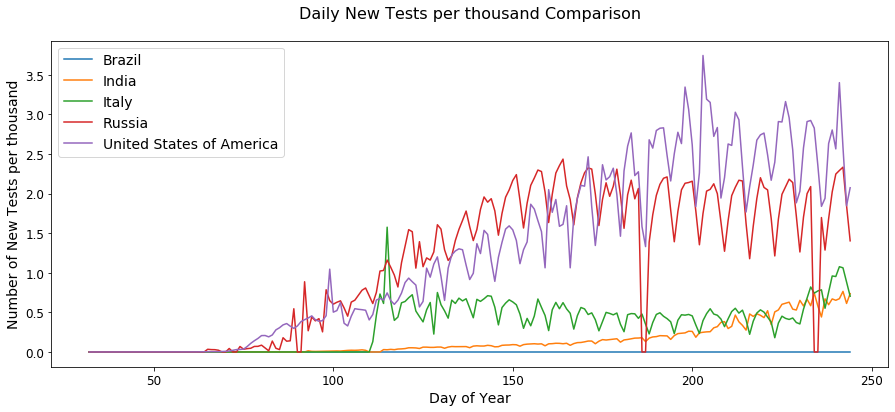

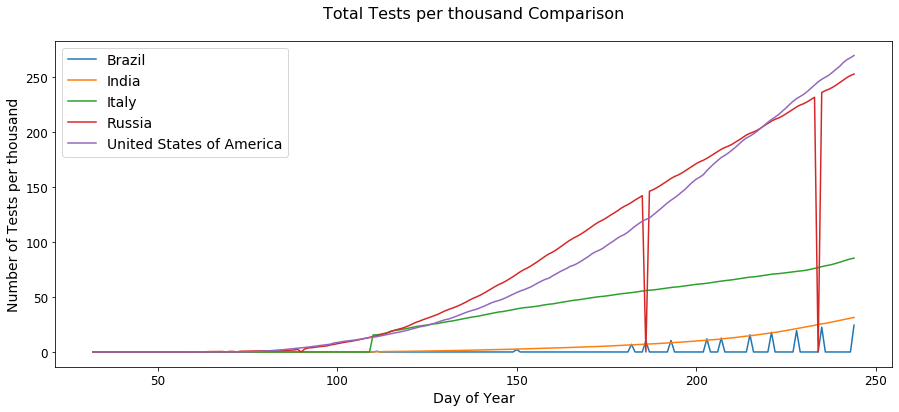

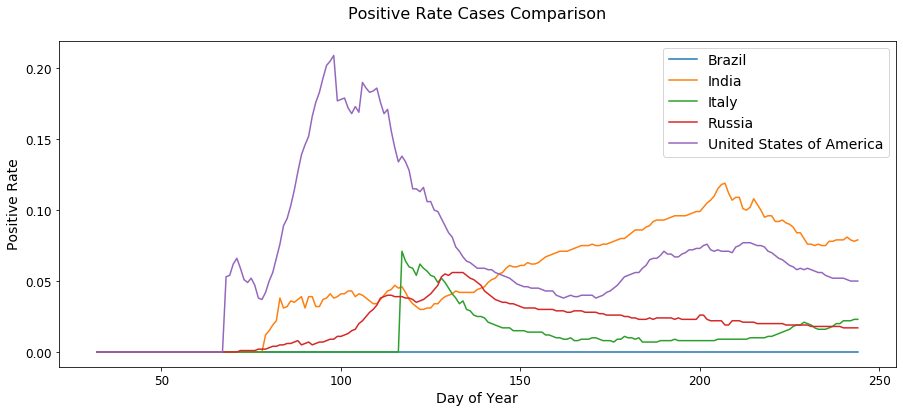

In [7]:
all_graph_combinations = [['total_cases', 'Total Cases Comparison', 'Number of Cases'],
['total_cases_per_million', 'Total Cases per mill. Comparison', 'Number of Cases per mill.'],
['new_cases', 'Daily New Cases Comparison', 'Number of New Cases'],
['new_cases_per_million', 'Daily New Cases per mill. Comparison', 'Number of New Cases per mill.'],
['total_deaths', 'Total Deaths Comparison', 'Number of Deaths'],
['total_deaths_per_million', 'Total Deaths per mill. Comparison', 'Number of Deaths per mill.'],
['new_deaths', 'Daily New Deaths Comparison', 'Number of Deaths'],
['new_deaths_per_million', 'Daily New Deaths per mill. Comparison', 'Number of New Deaths per mill.'],
['new_tests_per_thousand', 'Daily New Tests per thousand Comparison', 'Number of New Tests per thousand'],
['total_tests_per_thousand', 'Total Tests per thousand Comparison', 'Number of Tests per thousand'],
['positive_rate', 'Positive Rate Cases Comparison', 'Positive Rate']]
for i in all_graph_combinations:
    vis_df_fn = vis_df[['location', 'dayofyear', i[0]]]
    plt_line(vis_df_fn, 'dayofyear', 'location', i[1], 'Day of Year', i[2])

<h1><b>Machine Learning Models</b></h1>

In [8]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn import preprocessing


In [9]:
X = owid[['new_cases', 'new_cases_per_million', 'new_tests', 'new_tests_per_thousand', 'positive_rate', 'stringency_index', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']]
y = owid['new_deaths'].values
X.head()

,new_cases,new_cases_per_million,new_tests,new_tests_per_thousand,positive_rate,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,2,18.733,0.0,0.0,0.0,88.89,584.8,41.2,13.085,7.452,35973.781,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
1,0,0.000,0.0,0.0,0.0,88.89,584.8,41.2,13.085,7.452,35973.781,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
2,2,18.733,0.0,0.0,0.0,88.89,584.8,41.2,13.085,7.452,35973.781,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
3,0,0.000,0.0,0.0,0.0,88.89,584.8,41.2,13.085,7.452,35973.781,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0
4,0,0.000,0.0,0.0,0.0,88.89,584.8,41.2,13.085,7.452,35973.781,0.0,11.62,0.0,0.0,0.0,0.0,76.29,0.0


<h3>Preprocessing</h3>

In [10]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[-0.17540687, -0.04609061, -0.15702312, ..., -1.08404211,
         0.40981894, -3.36490222],
       [-0.1758732 , -0.36813944, -0.15702312, ..., -1.08404211,
         0.40981894, -3.36490222],
       [-0.17540687, -0.04609061, -0.15702312, ..., -1.08404211,
         0.40981894, -3.36490222],
       ...,
       [-0.15348944, -0.25709938, -0.13657303, ..., -0.38738191,
        -1.57658406, -0.76276598],
       [-0.17167624, -0.3473205 , -0.14597199, ..., -0.38738191,
        -1.57658406, -0.76276598],
       [-0.17447421, -0.36119406, -0.14167638, ..., -0.38738191,
        -1.57658406, -0.76276598]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (26739, 19) (26739,)
Test set: (6685, 19) (6685,)


<h1>K Nearest Neighbor(KNN)</h1>

In [12]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    mean_acc[n-1]=np.mean(yhat==y_test);
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.55332835, 0.59147345, 0.58279731, 0.58967838, 0.59326851,
       0.59491399, 0.59581152, 0.59581152, 0.59386687, 0.59685864,
       0.59790576, 0.59895288, 0.60089753, 0.60044877])

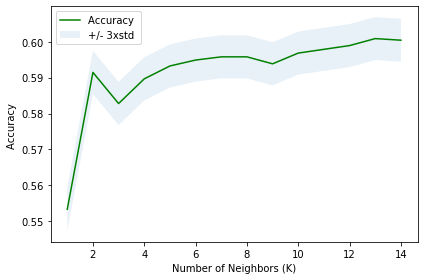

The best accuracy was with 0.6008975317875841 with k= 13


In [13]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)


In [14]:
k = mean_acc.argmax()+1
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhat = kNN_model.predict(X_test)
yhat

array([75,  1,  0, ..., 10,  0,  0], dtype=int64)

In [15]:
print("K Nearest Neighbor(KNN) accuracy: ", metrics.accuracy_score(y_test, yhat))
print(f1_score(y_test, yhat, average='weighted'))
print(jaccard_score(y_test, yhat, average='weighted'))

K Nearest Neighbor(KNN) accuracy:  0.6008975317875841
0.5546096154690082
0.48373034168217227


<h1>Decision Tree</h1>

In [16]:
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
DT_model.fit(X_train,y_train)
yhat = DT_model.predict(X_test)
yhat

array([19,  3,  0, ...,  0,  0,  0], dtype=int64)

In [17]:
print("Decision Tree Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("\n")
print(f1_score(y_test, yhat, average='weighted'))
print(jaccard_score(y_test, yhat, average='weighted'))

Decision Tree Accuracy:  0.5943156320119671


0.5021976811963772
0.4291684241651722


<h1>Support Vector Machine</h1>

In [18]:
SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_train, y_train)
yhat = SVM_model.predict(X_test)
yhat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
print("SVM's Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("\n")
print(f1_score(y_test, yhat, average='weighted'))
print(jaccard_score(y_test, yhat, average='weighted'))

SVM's Accuracy:  0.5956619296933433


0.46508059090127235
0.3780441556745146


<h1>Logistic Regression</h1>

In [20]:
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_test)
yhat

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [21]:
print("Logistic's Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("\n")
print(f1_score(y_test, yhat, average='weighted'))
print(jaccard_score(y_test, yhat, average='weighted'))

Logistic's Accuracy:  0.5877337322363501


0.4674160439577185
0.3829509058711217


In [22]:
pd.DataFrame(
{'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],
'Accuracy':[round(0.6008975317875841,2),round(0.5943156320119671,2),round(0.5956619296933433,2),round(0.5877337322363501,2)],
'Jacard':[round(0.48373034168217227,2),round(0.4291684241651722,2),round(0.3780441556745146,2),round(0.3829509058711217,2)],
'F1-score':[round(0.5546096154690082,2),round(0.5021976811963772,2),round(0.46508059090127235,2),round(0.4674160439577185,2)]})

,Algorithm,Accuracy,Jacard,F1-score
0,KNN,0.60,0.48,0.55
1,Decision Tree,0.59,0.43,0.50
2,SVM,0.60,0.38,0.47
3,Logistic Regression,0.59,0.38,0.47
